# Setup

In [1]:
import pickle
import matplotlib.pyplot as plt
import sys
import os
module_path = os.path.abspath(os.path.join('/home/razorin/tabularts/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import dataset
import torch
from pprint import pprint
import pandas as pd
import seaborn as sns
import sklearn
from  sklearn.manifold import TSNE
from  sklearn.decomposition import PCA
from  sklearn.preprocessing import KBinsDiscretizer
from  sklearn.preprocessing import MinMaxScaler
from  sklearn.preprocessing import RobustScaler
from  sklearn.preprocessing import StandardScaler
from  sklearn.preprocessing import QuantileTransformer
import numpy as np
import math

In [2]:
pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', -1)

In [3]:
data_type = "prsa"
name_suffix = ""
# name_suffix = "timedelta"

In [4]:
if data_type == "prsa":
    with open(f"../data/prsa/PRSADataset_labeled{name_suffix}.pkl", "rb") as f:
        dataset = pickle.load(f)

# Full data

In [5]:
# FYI: Stations order when the dataset samples were preprared
stations = []
for group in dataset.data.groupby("station"):
    station_name = group[0]
    stations.append(station_name)
print(stations)

['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan', 'Wanliu', 'Wanshouxigong']


In [6]:
# FYI: raw initial data
os.chdir("/home/razorin/tabularts/")
raw_data = dataset.read_data(dataset.data_root, dataset.nrows)
raw_data["timestamp_raw"] = pd.to_datetime(dict(year=raw_data['year'], month=raw_data['month'], day=raw_data['day'], hour=raw_data['hour'])).astype(int)
raw_data["date_raw"] = pd.to_datetime(dict(year=raw_data['year'], month=raw_data['month'], day=raw_data['day'], hour=raw_data['hour']))
raw_data['year_month'] = raw_data['date_raw'].dt.strftime('%Y-%m')
raw_data['weekday'] = raw_data['date_raw'].dt.dayofweek
raw_data = raw_data.sort_values(by=["station", "timestamp_raw"])
raw_data

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,PRES,DEWP,RAIN,wd,WSPM,station,timestamp_raw,date_raw,year_month,weekday
35064,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,1362096000000000000,2013-03-01 00:00:00,2013-03,4
35065,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,1362099600000000000,2013-03-01 01:00:00,2013-03,4
35066,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,1362103200000000000,2013-03-01 02:00:00,2013-03,4
35067,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,1362106800000000000,2013-03-01 03:00:00,2013-03,4
35068,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,1362110400000000000,2013-03-01 04:00:00,2013-03,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,...,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong,1488308400000000000,2017-02-28 19:00:00,2017-02,1
35060,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,...,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong,1488312000000000000,2017-02-28 20:00:00,2017-02,1
35061,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,...,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong,1488315600000000000,2017-02-28 21:00:00,2017-02,1
35062,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,...,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong,1488319200000000000,2017-02-28 22:00:00,2017-02,1


In [7]:
raw_data.columns

Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station',
       'timestamp_raw', 'date_raw', 'year_month', 'weekday'],
      dtype='object')

In [8]:
preproc_data = dataset.data # Do NOT sort again (keep original timestamp sort)
preprocessed_data = []
for group, data in preproc_data.groupby("station"):
    preprocessed_data.append(data)
preprocessed_data = pd.concat(preprocessed_data)
preprocessed_data

,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd,station,year,month,day,hour,weekday,PM2.5,PM10,outlier
35064,19.0,2.0,6.0,36.0,6.0,42.0,3.0,48.0,47.0,NNW,Aotizhongxin,2013,3,1,0,4,4.0,4.0,0
35065,19.0,2.0,6.0,36.0,6.0,43.0,3.0,48.0,48.0,N,Aotizhongxin,2013,3,1,1,4,8.0,8.0,0
35066,21.0,3.0,6.0,35.0,6.0,43.0,3.0,48.0,49.0,NNW,Aotizhongxin,2013,3,1,2,4,7.0,7.0,0
35067,31.0,4.0,6.0,34.0,5.0,44.0,2.0,48.0,43.0,NW,Aotizhongxin,2013,3,1,3,4,6.0,6.0,0
35068,32.0,5.0,6.0,34.0,5.0,45.0,2.0,48.0,35.0,N,Aotizhongxin,2013,3,1,4,4,3.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,16.0,13.0,10.0,34.0,22.0,29.0,5.0,48.0,39.0,NW,Wanshouxigong,2017,2,28,19,1,11.0,32.0,0
35060,16.0,24.0,14.0,27.0,21.0,29.0,6.0,48.0,13.0,WNW,Wanshouxigong,2017,2,28,20,1,13.0,32.0,0
35061,19.0,22.0,14.0,28.0,21.0,30.0,8.0,48.0,18.0,NW,Wanshouxigong,2017,2,28,21,1,14.0,28.0,0
35062,19.0,17.0,10.0,30.0,20.0,31.0,8.0,48.0,21.0,NNW,Wanshouxigong,2017,2,28,22,1,12.0,23.0,0


In [9]:
windows_outliers = preprocessed_data[preprocessed_data["station"] == "Aotizhongxin"]["outlier"]
windows_outliers = windows_outliers.rolling(dataset.seq_len, step=dataset.stride, closed="left").sum()[2:]
windows_outliers = np.where(windows_outliers >= 1, 1, 0) # Rolling in pd starts with the n-1 prior rows (unintuitive)
windows_outliers.shape

(6361,)

In [10]:
samples = dataset.samples
print(len(samples))

targets = dataset.targets
print(len(targets))

print(preprocessed_data.shape[0]/dataset.stride)

67018
67018
76433.6


In [11]:
vocab_keys = list(dataset.vocab.token2id.keys())
for k in vocab_keys:
    print(f"\n--{k}--")
    # pprint(dataset.vocab.token2id[k])
    print(len(dataset.vocab.token2id[k]))


--SPECIAL--
7

--SO2--
29

--NO2--
50

--CO--
27

--O3--
45

--TEMP--
50

--PRES--
50

--DEWP--
50

--RAIN--
2

--WSPM--
33

--wd--
16

--station--
12

--year--
5

--month--
12

--day--
31

--hour--
24

--weekday--
7


In [12]:
dataset.vocab.token2id["SPECIAL"]

OrderedDict([('[UNK]', [0, 0]),
             ('[SEP]', [1, 1]),
             ('[PAD]', [2, 2]),
             ('[CLS]', [3, 3]),
             ('[MASK]', [4, 4]),
             ('[BOS]', [5, 5]),
             ('[EOS]', [6, 6])])

# Sample

In [13]:
def get_final_id(windows_outliers, sample_id):
    """
    Find the starting index in the the original data
    that corresponds to a given dataset sample ID,
    accoutning for detected outliers when buildind the dataset
    """
    noutliers_included =  windows_outliers[:sample_id+1].sum()
    next_safe_sample = 0
    noutliers_additional = 0
    if noutliers_included >= 1:
        noutliers_additional = 0
        next_safe_sample = 0
        i = 0
        while next_safe_sample < noutliers_included:
            if windows_outliers[sample_id+1+i] == 1:
                noutliers_additional += 1
                i += 1
            else:
                next_safe_sample += 1
    final_id = sample_id + noutliers_included + noutliers_additional

    if windows_outliers[final_id] == 1: # is the final index an outlier as well
        return final_id + get_final_id(windows_outliers[final_id:], 0)
    else:
        return final_id

In [14]:
sample_id = 38 # Only works for samples of the first station (because the rolling windows for outliers is NOT grouped by station first)
stride = dataset.stride
final_id = get_final_id(windows_outliers, sample_id)
raw_sample = raw_data[stride * final_id: dataset.seq_len + stride * final_id]
preprocessed_sample = preprocessed_data[stride * final_id: dataset.seq_len + stride * final_id]
pytorch_sample = torch.tensor(samples[sample_id]).reshape(dataset.seq_len, -1)
pytorch_target = torch.tensor(targets[sample_id])

In [15]:
raw_sample

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,PRES,DEWP,RAIN,wd,WSPM,station,timestamp_raw,date_raw,year_month,weekday
35262,2013,3,9,6,110.0,153.0,44.0,83.0,2600.0,68.0,...,992.2,-2.5,0.0,NE,1.0,Aotizhongxin,1362808800000000000,2013-03-09 06:00:00,2013-03,5
35263,2013,3,9,7,108.0,143.0,51.0,85.0,2100.0,68.0,...,992.9,-2.1,0.0,NE,1.8,Aotizhongxin,1362812400000000000,2013-03-09 07:00:00,2013-03,5
35264,2013,3,9,8,104.0,139.0,70.0,82.0,2100.0,68.0,...,994.1,-1.7,0.0,E,2.6,Aotizhongxin,1362816000000000000,2013-03-09 08:00:00,2013-03,5
35265,2013,3,9,9,113.0,166.0,108.0,86.0,1899.0,68.0,...,995.9,-0.4,0.0,NNW,3.3,Aotizhongxin,1362819600000000000,2013-03-09 09:00:00,2013-03,5
35266,2013,3,9,10,145.0,272.0,122.0,86.0,2200.0,68.0,...,998.3,-4.6,0.0,NNW,7.7,Aotizhongxin,1362823200000000000,2013-03-09 10:00:00,2013-03,5
35267,2013,3,9,11,69.0,587.0,50.0,21.0,400.0,68.0,...,1001.3,-9.1,0.0,NNW,7.4,Aotizhongxin,1362826800000000000,2013-03-09 11:00:00,2013-03,5
35269,2013,3,9,13,49.0,628.0,4.0,7.0,300.0,76.0,...,1006.5,-17.0,0.0,NNW,7.2,Aotizhongxin,1362834000000000000,2013-03-09 13:00:00,2013-03,5
35270,2013,3,9,14,47.0,662.0,3.0,6.0,300.0,81.0,...,1008.1,-16.8,0.0,NNW,6.7,Aotizhongxin,1362837600000000000,2013-03-09 14:00:00,2013-03,5
35271,2013,3,9,15,28.0,443.0,3.0,8.0,300.0,81.0,...,1009.4,-17.1,0.0,N,3.9,Aotizhongxin,1362841200000000000,2013-03-09 15:00:00,2013-03,5
35272,2013,3,9,16,21.0,263.0,3.0,9.0,300.0,81.0,...,1010.8,-17.8,0.0,N,4.8,Aotizhongxin,1362844800000000000,2013-03-09 16:00:00,2013-03,5


In [16]:
preprocessed_sample

,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd,station,year,month,day,hour,weekday,PM2.5,PM10,outlier
35262,45.0,41.0,45.0,33.0,11.0,0.0,19.0,48.0,15.0,NE,Aotizhongxin,2013,3,9,6,5,110.0,153.0,0
35263,46.0,41.0,42.0,33.0,14.0,1.0,20.0,48.0,32.0,NE,Aotizhongxin,2013,3,9,7,5,108.0,143.0,0
35264,48.0,41.0,42.0,33.0,18.0,1.0,20.0,48.0,41.0,E,Aotizhongxin,2013,3,9,8,5,104.0,139.0,0
35265,49.0,42.0,40.0,33.0,27.0,3.0,21.0,48.0,44.0,NNW,Aotizhongxin,2013,3,9,9,5,113.0,166.0,0
35266,49.0,42.0,43.0,33.0,27.0,6.0,17.0,48.0,49.0,NNW,Aotizhongxin,2013,3,9,10,5,145.0,272.0,0
35267,46.0,11.0,10.0,33.0,24.0,10.0,12.0,48.0,49.0,NNW,Aotizhongxin,2013,3,9,11,5,69.0,587.0,0
35269,19.0,2.0,6.0,36.0,20.0,19.0,4.0,48.0,49.0,NNW,Aotizhongxin,2013,3,9,13,5,49.0,628.0,0
35270,16.0,1.0,6.0,37.0,20.0,21.0,5.0,48.0,49.0,NNW,Aotizhongxin,2013,3,9,14,5,47.0,662.0,0
35271,16.0,2.0,6.0,37.0,20.0,23.0,4.0,48.0,46.0,N,Aotizhongxin,2013,3,9,15,5,28.0,443.0,0
35272,16.0,3.0,6.0,37.0,20.0,25.0,4.0,48.0,48.0,N,Aotizhongxin,2013,3,9,16,5,21.0,263.0,0


In [17]:
pytorch_sample

tensor([[ 27,  52, 103, 138, 162, 236, 300, 308, 312, 343, 365, 374, 376, 407,
         424, 444],
        [ 24,  52,  98, 138, 202, 229, 265, 308, 323, 343, 365, 374, 376, 407,
         428, 444],
        [ 26,  52,  98, 138, 176, 229, 265, 308, 324, 347, 365, 374, 376, 407,
         429, 444],
        [ 25,  62, 108, 138, 166, 226, 302, 308, 339, 350, 365, 374, 376, 407,
         422, 444],
        [ 25,  62, 101, 138, 166, 246, 267, 308, 332, 350, 365, 374, 376, 407,
         435, 444],
        [ 24,  78,  87, 138, 204, 231, 270, 308, 332, 350, 365, 374, 376, 407,
         437, 444],
        [  9,  68,  86, 119, 167, 241, 272, 308, 332, 350, 365, 374, 376, 407,
         433, 444],
        [  8,  64,  86, 131, 167, 245, 299, 308, 332, 350, 365, 374, 376, 407,
         436, 444],
        [  8,  68,  86, 131, 167, 214, 272, 308, 337, 346, 365, 374, 376, 407,
         434, 444],
        [  8,  50,  86, 131, 167, 254, 272, 308, 331, 346, 365, 374, 376, 407,
         432, 444]])

In [18]:
pytorch_target

tensor([[110., 153.],
        [108., 143.],
        [104., 139.],
        [113., 166.],
        [145., 272.],
        [ 69., 587.],
        [ 49., 628.],
        [ 47., 662.],
        [ 28., 443.],
        [ 21., 263.]], dtype=torch.float64)

In [18]:
def find_sample_above_pm(min_pm: float, samples: list, targets: list, seq_len: int=10, n:int=1):
    pm = 0
    i = -1
    occur = 0
    while ((pm < min_pm) or (occur < n)):
        i += 1
        target = torch.tensor(targets[i])
        pm = target.max()
        if pm >= min_pm:
            occur += 1
    return (
        i,
        torch.tensor(samples[i]).reshape(seq_len, -1),
        torch.tensor(targets[i])
    )

In [19]:
find_sample_above_pm(min_pm=600, samples=samples, targets=targets, seq_len=10, n=1)

(38,
 tensor([[ 27,  52, 103, 138, 162, 236, 300, 308, 312, 343, 365, 374, 376, 407,
          424, 444],
         [ 24,  52,  98, 138, 202, 229, 265, 308, 323, 343, 365, 374, 376, 407,
          428, 444],
         [ 26,  52,  98, 138, 176, 229, 265, 308, 324, 347, 365, 374, 376, 407,
          429, 444],
         [ 25,  62, 108, 138, 166, 226, 302, 308, 339, 350, 365, 374, 376, 407,
          422, 444],
         [ 25,  62, 101, 138, 166, 246, 267, 308, 332, 350, 365, 374, 376, 407,
          435, 444],
         [ 24,  78,  87, 138, 204, 231, 270, 308, 332, 350, 365, 374, 376, 407,
          437, 444],
         [  9,  68,  86, 119, 167, 241, 272, 308, 332, 350, 365, 374, 376, 407,
          433, 444],
         [  8,  64,  86, 131, 167, 245, 299, 308, 332, 350, 365, 374, 376, 407,
          436, 444],
         [  8,  68,  86, 131, 167, 214, 272, 308, 337, 346, 365, 374, 376, 407,
          434, 444],
         [  8,  50,  86, 131, 167, 254, 272, 308, 331, 346, 365, 374, 376, 407,
      

# Explore

In [31]:
# Summary stats on targets
preprocessed_data_wo_meas_outliers = preprocessed_data[preprocessed_data["PM10"] >= preprocessed_data["PM2.5"]].copy(deep=True) # Measurement error otherwise (removed from pytorch samples)
preprocessed_data_wo_meas_outliers[["PM2.5", "PM10"]].describe()

,PM2.5,PM10
count,364540.000000,364540.000000
mean,77.806045,105.380690
std,79.268851,91.689088
min,2.000000,2.000000
25%,20.000000,36.000000
50%,53.000000,83.000000
75%,108.000000,146.000000
max,835.000000,999.000000


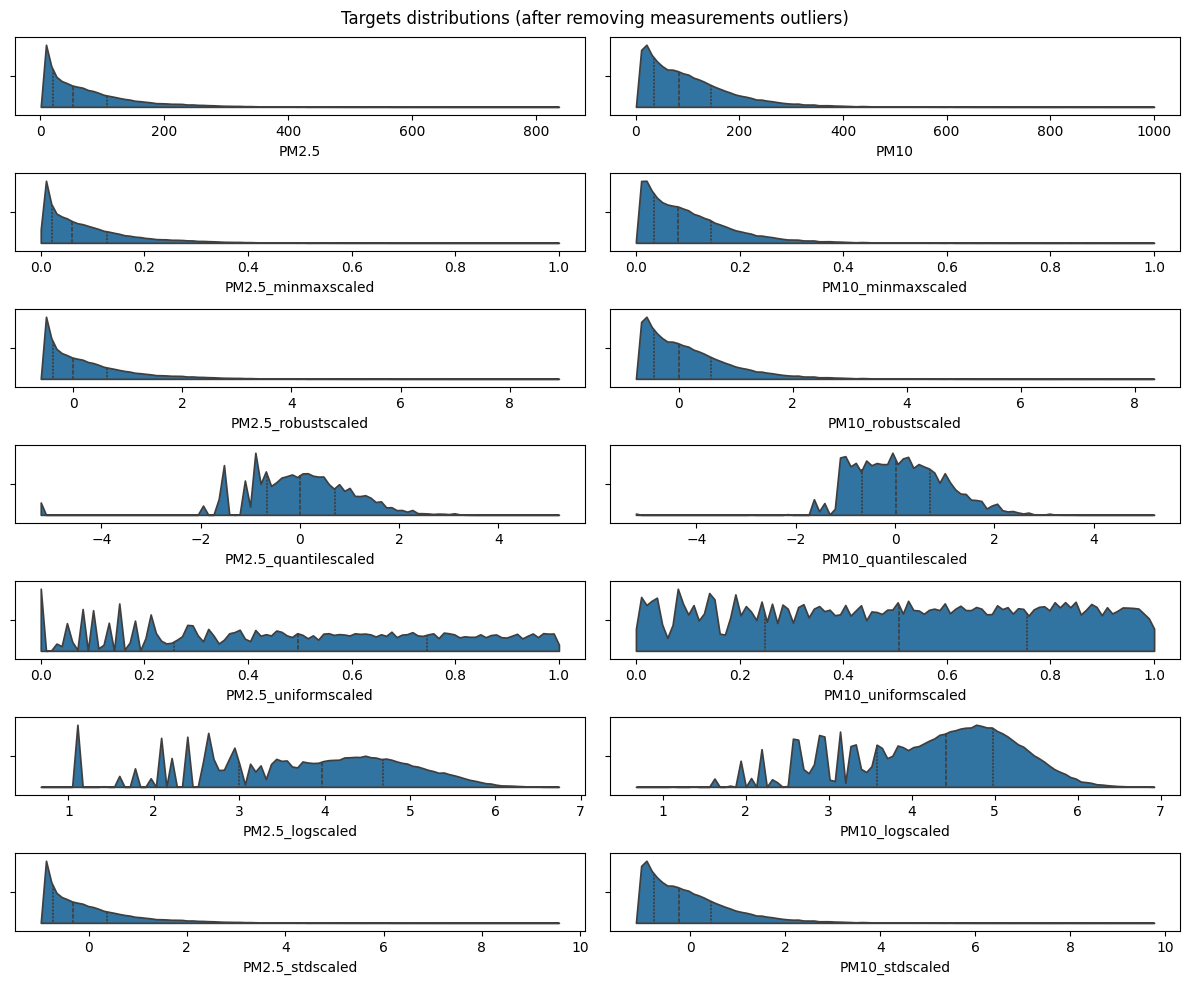

In [51]:
# Distribution of targets and comparisons of transformations

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 10))
sns.violinplot(
    ax=axes[0][0],
    x='PM2.5', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    cut=preprocessed_data_wo_meas_outliers["PM2.5"].min(),
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[0][1],
    x='PM10', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    cut=preprocessed_data_wo_meas_outliers["PM10"].min(),
    inner="quart",
    bw_adjust=.1,
)

minmax_scaler = MinMaxScaler()
preprocessed_data_wo_meas_outliers[["PM2.5_minmaxscaled", "PM10_minmaxscaled"]] = minmax_scaler.fit_transform(preprocessed_data_wo_meas_outliers[["PM2.5", "PM10"]] )
sns.violinplot(
    ax=axes[1][0],
    x='PM2.5_minmaxscaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    cut=0,
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[1][1],
    x='PM10_minmaxscaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    cut=0,
    bw_adjust=.1,
)

robust_scaler = RobustScaler()
preprocessed_data_wo_meas_outliers[["PM2.5_robustscaled", "PM10_robustscaled"]] = robust_scaler.fit_transform(preprocessed_data_wo_meas_outliers[["PM2.5", "PM10"]] )
sns.violinplot(
    ax=axes[2][0],
    x='PM2.5_robustscaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[2][1],
    x='PM10_robustscaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    bw_adjust=.1,
)

quantile_scaler = QuantileTransformer(output_distribution="normal")
preprocessed_data_wo_meas_outliers[["PM2.5_quantilescaled", "PM10_quantilescaled"]] = quantile_scaler.fit_transform(preprocessed_data_wo_meas_outliers[["PM2.5", "PM10"]] )
sns.violinplot(
    ax=axes[3][0],
    x='PM2.5_quantilescaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[3][1],
    x='PM10_quantilescaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    bw_adjust=.1,
)

uniform_scaler = QuantileTransformer(output_distribution="uniform")
preprocessed_data_wo_meas_outliers[["PM2.5_uniformscaled", "PM10_uniformscaled"]] = uniform_scaler.fit_transform(preprocessed_data_wo_meas_outliers[["PM2.5", "PM10"]] )
sns.violinplot(
    ax=axes[4][0],
    x='PM2.5_uniformscaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    cut=0,
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[4][1],
    x='PM10_uniformscaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    cut=0,
    bw_adjust=.1,
)

preprocessed_data_wo_meas_outliers["PM2.5_logscaled"] = preprocessed_data_wo_meas_outliers["PM2.5"].map(lambda x: np.log(x))
preprocessed_data_wo_meas_outliers["PM10_logscaled"] = preprocessed_data_wo_meas_outliers["PM10"].map(lambda x: np.log(x))
sns.violinplot(
    ax=axes[5][0],
    x='PM2.5_logscaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[5][1],
    x='PM10_logscaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    bw_adjust=.1,
)

std_scaler = StandardScaler()
preprocessed_data_wo_meas_outliers[["PM2.5_stdscaled", "PM10_stdscaled"]] = std_scaler.fit_transform(preprocessed_data_wo_meas_outliers[["PM2.5", "PM10"]] )
sns.violinplot(
    ax=axes[6][0],
    x='PM2.5_stdscaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[6][1],
    x='PM10_stdscaled', 
    split=True,
    data=preprocessed_data_wo_meas_outliers,
    inner="quart",
    bw_adjust=.1,
)

plt.suptitle("Targets distributions (after removing measurements outliers)")
plt.tight_layout()

# Take aways:
# - Targets distributions are right-skewed, lots of outliers
# - We use StdScaler for the targets (and with no activation in the last layer)

In [58]:
# Dispersion targets outliers

def get_IQR_outlier_cutoff(df, column, iqr_scalar=1.5):

     Q1 = df[column].quantile(0.25)
     Q3 = df[column].quantile(0.75)
     IQR = Q3 - Q1
     lower_outliers_cutoff = (Q1 - iqr_scalar * IQR)
     higher_outliers_cutoff = (Q3 + iqr_scalar * IQR)
     return (lower_outliers_cutoff, higher_outliers_cutoff)

lower_outliers_cutoff_pm25, higher_outliers_cutoff_pm25 = get_IQR_outlier_cutoff(preprocessed_data_wo_meas_outliers, "PM2.5")
print(f"{lower_outliers_cutoff_pm25=}") 
print(f"{higher_outliers_cutoff_pm25=}")

lower_outliers_cutoff_pm10, higher_outliers_cutoff_pm10 = get_IQR_outlier_cutoff(preprocessed_data_wo_meas_outliers, "PM10")
print(f"{lower_outliers_cutoff_pm10=}") 
print(f"{higher_outliers_cutoff_pm10=}")

lower_outliers_cutoff_pm25=-112.0
higher_outliers_cutoff_pm25=240.0
lower_outliers_cutoff_pm10=-129.0
higher_outliers_cutoff_pm10=311.0


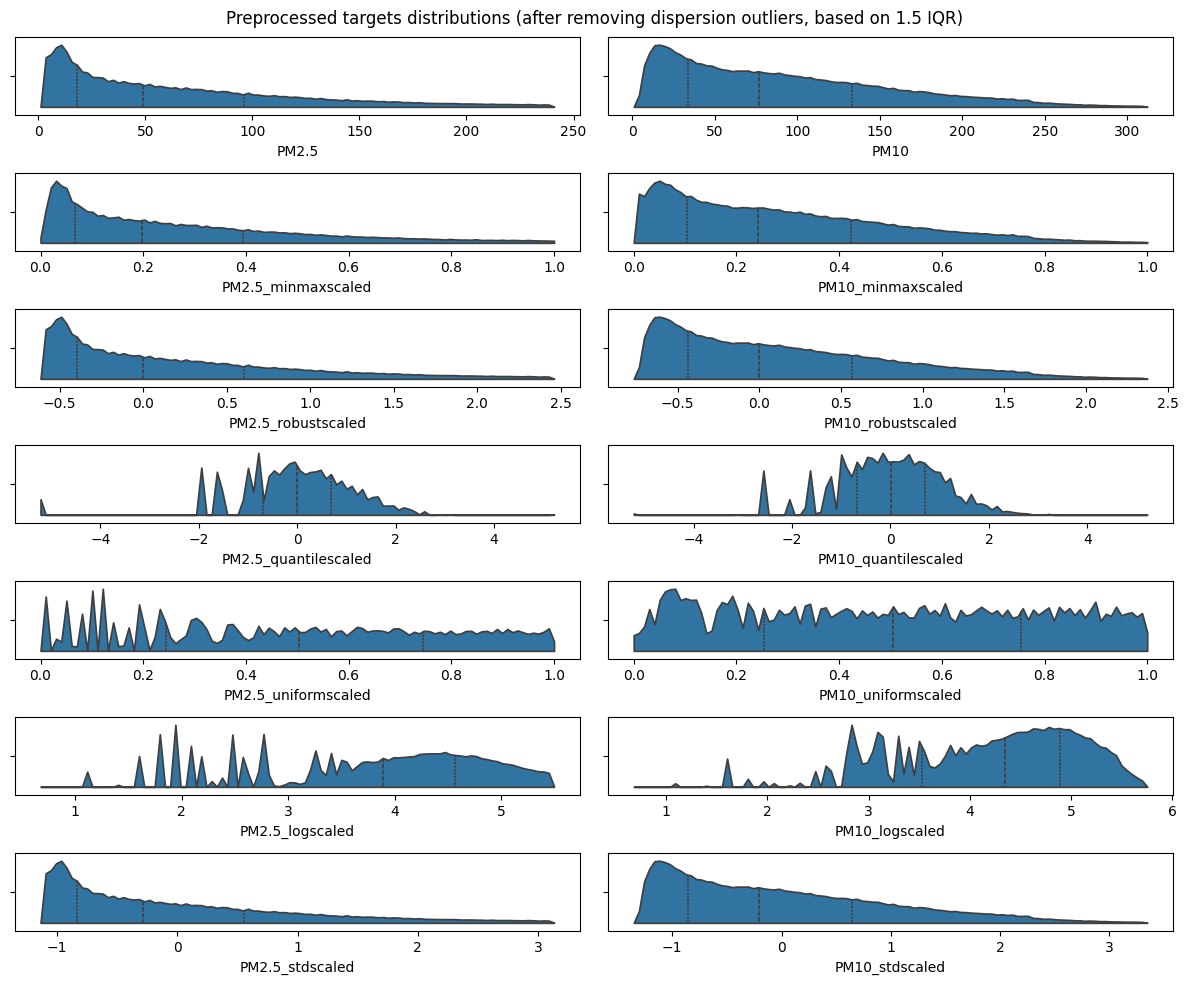

In [53]:
# Distribution of *outlier* targets and comparisons of transformations

preprocessed_data_wo_disp_outliers = preprocessed_data_wo_meas_outliers[
    (preprocessed_data_wo_meas_outliers["PM2.5"] <= higher_outliers_cutoff_pm25) &
    (preprocessed_data_wo_meas_outliers["PM10"] <= higher_outliers_cutoff_pm10)
].copy(deep=True)

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 10))
sns.violinplot(
    ax=axes[0][0],
    x='PM2.5', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    cut=preprocessed_data_wo_disp_outliers["PM2.5"].min(),
    inner="quart",
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[0][1],
    x='PM10', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    cut=preprocessed_data_wo_disp_outliers["PM10"].min(),
    inner="quart",
    bw_adjust=.1,
)

minmax_scaler = MinMaxScaler()
preprocessed_data_wo_disp_outliers[["PM2.5_minmaxscaled", "PM10_minmaxscaled"]] = minmax_scaler.fit_transform(preprocessed_data_wo_disp_outliers[["PM2.5", "PM10"]] )
sns.violinplot(
    ax=axes[1][0],
    x='PM2.5_minmaxscaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    cut=0,
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[1][1],
    x='PM10_minmaxscaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    cut=0,
    bw_adjust=.1,
)

robust_scaler = RobustScaler()
preprocessed_data_wo_disp_outliers[["PM2.5_robustscaled", "PM10_robustscaled"]] = robust_scaler.fit_transform(preprocessed_data_wo_disp_outliers[["PM2.5", "PM10"]] )
sns.violinplot(
    ax=axes[2][0],
    x='PM2.5_robustscaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[2][1],
    x='PM10_robustscaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    bw_adjust=.1,
)

quantile_scaler = QuantileTransformer(output_distribution="normal")
preprocessed_data_wo_disp_outliers[["PM2.5_quantilescaled", "PM10_quantilescaled"]] = quantile_scaler.fit_transform(preprocessed_data_wo_disp_outliers[["PM2.5", "PM10"]] )
sns.violinplot(
    ax=axes[3][0],
    x='PM2.5_quantilescaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[3][1],
    x='PM10_quantilescaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    bw_adjust=.1,
)

uniform_scaler = QuantileTransformer(output_distribution="uniform")
preprocessed_data_wo_disp_outliers[["PM2.5_uniformscaled", "PM10_uniformscaled"]] = uniform_scaler.fit_transform(preprocessed_data_wo_disp_outliers[["PM2.5", "PM10"]] )
sns.violinplot(
    ax=axes[4][0],
    x='PM2.5_uniformscaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    cut=0,
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[4][1],
    x='PM10_uniformscaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    cut=0,
    bw_adjust=.1,
)

preprocessed_data_wo_disp_outliers["PM2.5_logscaled"] = preprocessed_data_wo_disp_outliers["PM2.5"].map(lambda x: np.log(x))
preprocessed_data_wo_disp_outliers["PM10_logscaled"] = preprocessed_data_wo_disp_outliers["PM10"].map(lambda x: np.log(x))
sns.violinplot(
    ax=axes[5][0],
    x='PM2.5_logscaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[5][1],
    x='PM10_logscaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    bw_adjust=.1,
)

std_scaler = StandardScaler()
preprocessed_data_wo_disp_outliers[["PM2.5_stdscaled", "PM10_stdscaled"]] = std_scaler.fit_transform(preprocessed_data_wo_disp_outliers[["PM2.5", "PM10"]] )
sns.violinplot(
    ax=axes[6][0],
    x='PM2.5_stdscaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[6][1],
    x='PM10_stdscaled', 
    split=True,
    data=preprocessed_data_wo_disp_outliers,
    inner="quart",
    bw_adjust=.1,
)

plt.suptitle("Preprocessed targets distributions (after removing dispersion outliers, based on 1.5 IQR)")
plt.tight_layout()

# Take aways:
# - Targets (without dispersion outliers) are still right-skewed

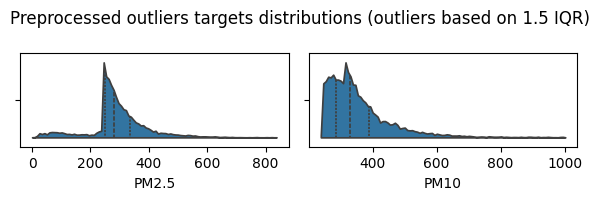

In [63]:
# Distribution of *outlier* targets and comparisons of transformations

outliers = preprocessed_data_wo_meas_outliers[
    (preprocessed_data_wo_meas_outliers["PM2.5"] > higher_outliers_cutoff_pm25) |
    (preprocessed_data_wo_meas_outliers["PM10"] > higher_outliers_cutoff_pm10)
].copy(deep=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
sns.violinplot(
    ax=axes[0],
    x='PM2.5', 
    split=True,
    data=outliers,
    inner="quart",
    cut=preprocessed_data_wo_meas_outliers["PM2.5"].min(),
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[1],
    x='PM10', 
    split=True,
    data=outliers,
    inner="quart",
    cut=preprocessed_data_wo_meas_outliers["PM10"].min(),
    bw_adjust=.1,
)

plt.suptitle("Preprocessed outliers targets distributions (outliers based on 1.5 IQR)")
plt.tight_layout()

# Take aways:
# - Outlier targets are also right skewed

extreme_lower_outliers_cutoff_pm25=-200.0
extreme_higher_outliers_cutoff_pm25=328.0
extreme_lower_outliers_cutoff_pm10=-239.0
extreme_higher_outliers_cutoff_pm10=421.0


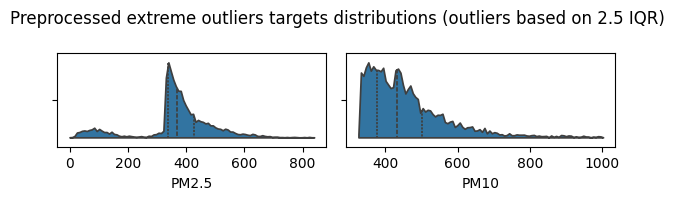

In [64]:
# Dispersion targets extreme outliers

extreme_lower_outliers_cutoff_pm25, extreme_higher_outliers_cutoff_pm25 = get_IQR_outlier_cutoff(preprocessed_data_wo_meas_outliers, "PM2.5", 2.5)
print(f"{extreme_lower_outliers_cutoff_pm25=}") 
print(f"{extreme_higher_outliers_cutoff_pm25=}")

extreme_lower_outliers_cutoff_pm10, extreme_higher_outliers_cutoff_pm10 = get_IQR_outlier_cutoff(preprocessed_data_wo_meas_outliers, "PM10",2.5)
print(f"{extreme_lower_outliers_cutoff_pm10=}") 
print(f"{extreme_higher_outliers_cutoff_pm10=}")

extreme_outliers = preprocessed_data_wo_meas_outliers[
    (preprocessed_data_wo_meas_outliers["PM2.5"] > extreme_higher_outliers_cutoff_pm25) |
    (preprocessed_data_wo_meas_outliers["PM10"] > extreme_higher_outliers_cutoff_pm10)
].copy(deep=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
sns.violinplot(
    ax=axes[0],
    x='PM2.5', 
    split=True,
    data=extreme_outliers,
    inner="quart",
    cut=preprocessed_data_wo_meas_outliers["PM2.5"].min(),
    bw_adjust=.1,
)
sns.violinplot(
    ax=axes[1],
    x='PM10', 
    split=True,
    data=extreme_outliers,
    inner="quart",
    cut=preprocessed_data_wo_meas_outliers["PM10"].min(),
    bw_adjust=.1,
)

plt.suptitle("Preprocessed extreme outliers targets distributions (outliers based on 2.5 IQR)")
plt.tight_layout()

# Take aways:
# 


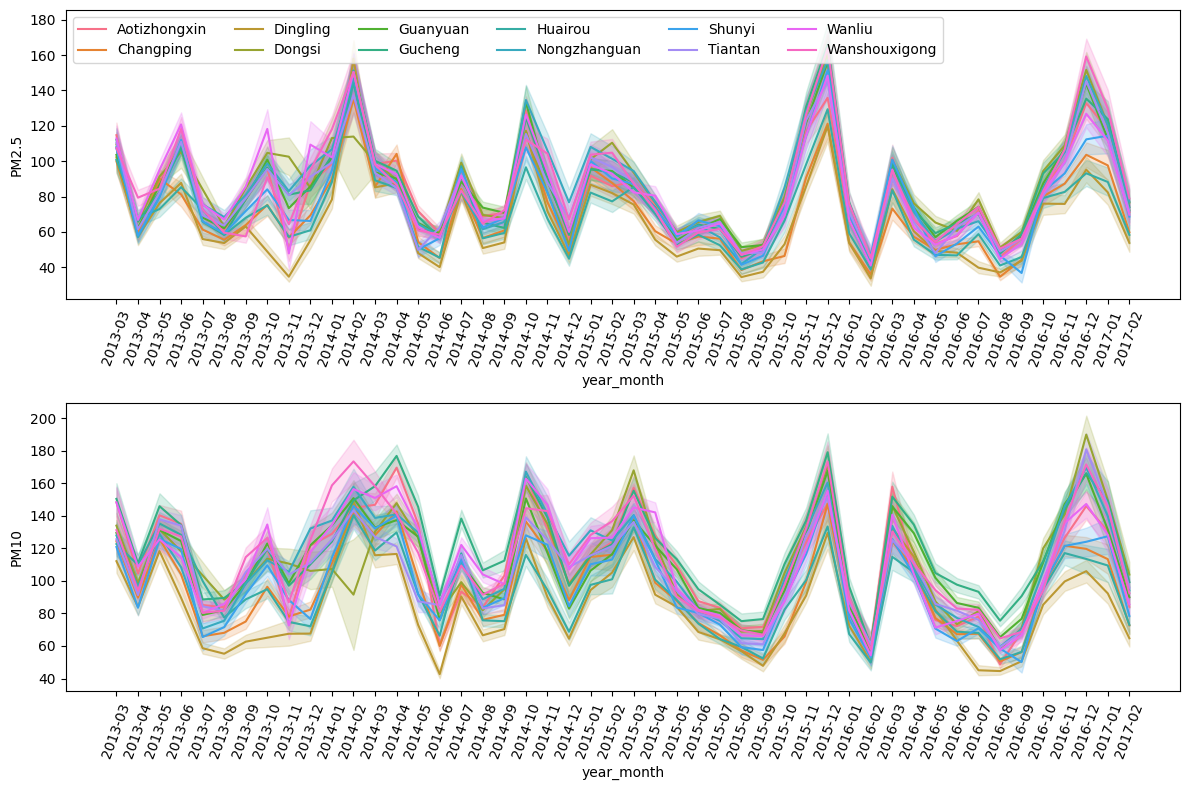

In [21]:
# Evolution of pollution over the years

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
sns.lineplot(
    ax=ax1,
    x='year_month', 
    y='PM2.5', 
    hue='station', 
    data=raw_data
)
sns.lineplot(
    ax=ax2,
    x='year_month', 
    y='PM10', 
    hue='station', 
    data=raw_data
)
ax1.legend(loc='upper left', ncol=6)
ax2.get_legend().remove()
ax1.tick_params(axis='x', labelrotation=70)
ax2.tick_params(axis='x', labelrotation=70)
plt.tight_layout()

# Take aways: 
# - year and month are important. 
# - PM2.5 and PM10 follow the same trends
# - station name matters

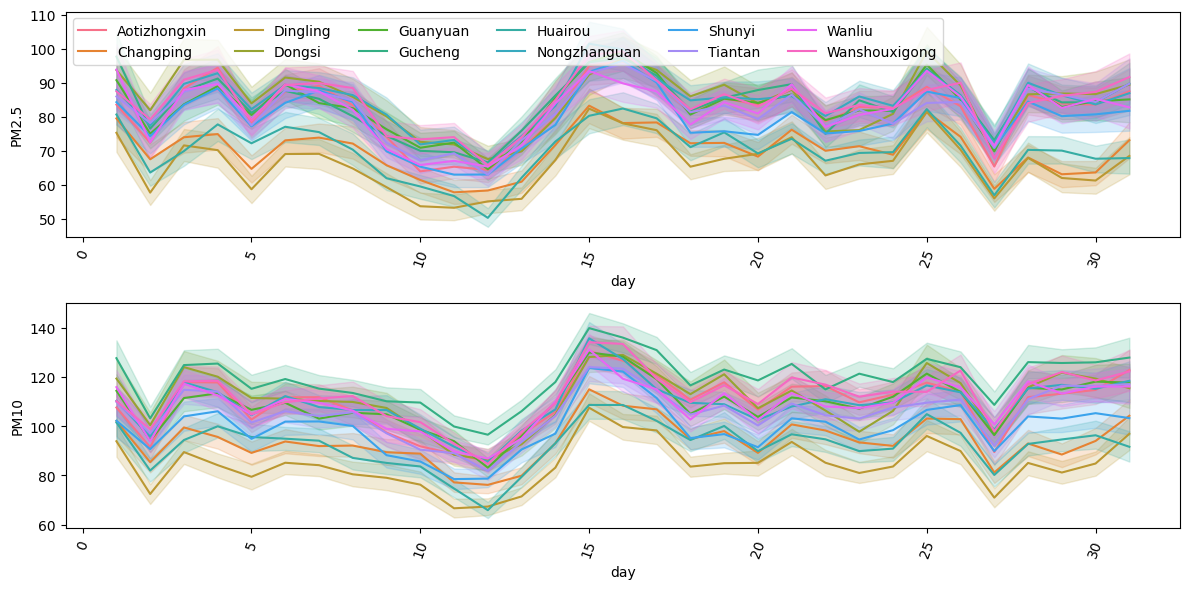

In [22]:
# Evolution of pollution by day of the month

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
sns.lineplot(
    ax=ax1,
    x='day', 
    y='PM2.5', 
    hue='station', 
    data=raw_data
)
sns.lineplot(
    ax=ax2,
    x='day', 
    y='PM10', 
    hue='station', 
    data=raw_data
)
ax1.legend(loc='upper left', ncol=6)
ax2.get_legend().remove()
ax1.tick_params(axis='x', labelrotation=70)
ax2.tick_params(axis='x', labelrotation=70)
plt.tight_layout()

# Take aways: 
# - day of the month matters

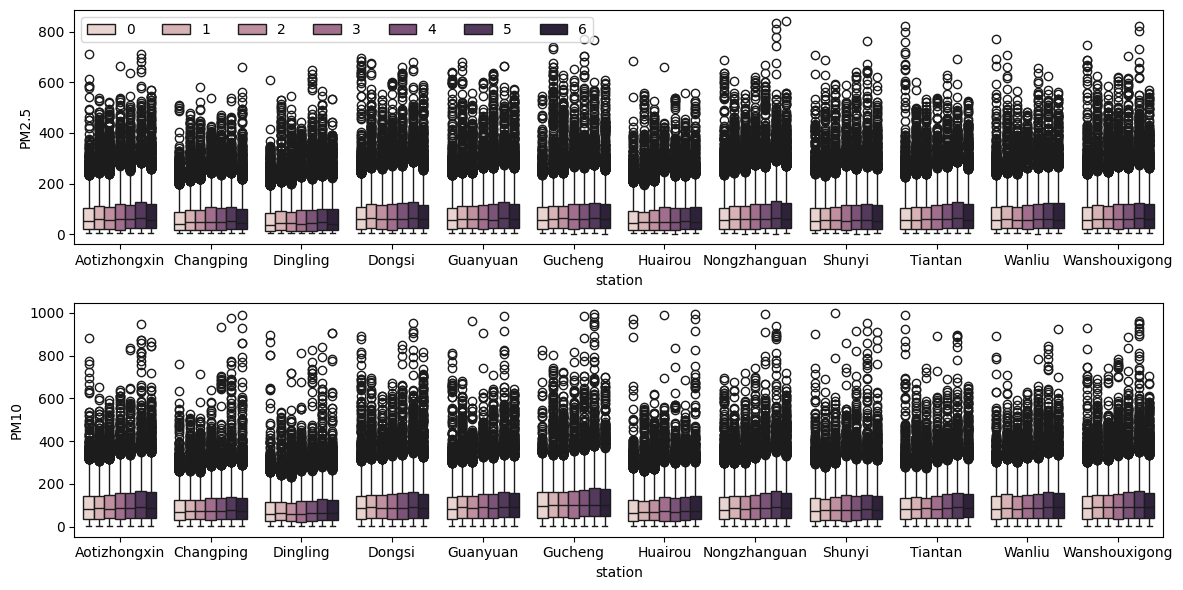

In [23]:
# Evolution of pollution by weekday

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
sns.boxplot(
    ax=ax1,
    x='station', 
    y='PM2.5', 
    hue='weekday', 
    data=raw_data
)
sns.boxplot(
    ax=ax2,
    x='station', 
    y='PM10', 
    hue='weekday', 
    data=raw_data
)
ax1.legend(loc='upper left', ncol=7)
ax2.get_legend().remove()
ax1.tick_params(axis='x', labelrotation=0)
ax2.tick_params(axis='x', labelrotation=0)
plt.tight_layout()

# Take aways: 
# - day of the week matters a little bit

In [24]:
# Outliers in pollution levels (PM10 < PM2.5)
n_hard_outliers = raw_data[raw_data["PM10"] < raw_data["PM2.5"]].shape[0]
print(n_hard_outliers / raw_data.shape[0])

# Take away:
# 4% of samples are inconsistent outliers (PM2.5 are included in PM10)
# cf. https://aqicn.org/faq/2013-02-02/why-is-pm25-often-higher-than-pm10/

0.046126310941784765


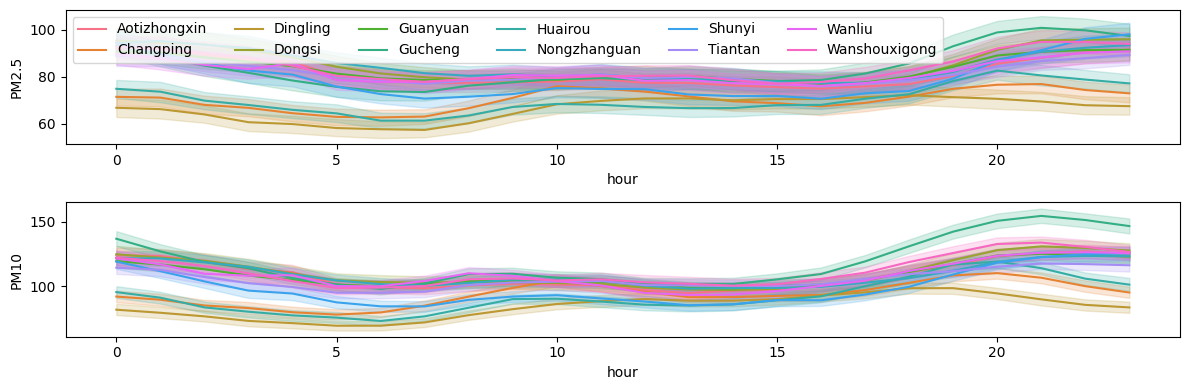

In [25]:
# Evolution of pollution by hour of the day

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))
sns.lineplot(
    ax=ax1,
    x='hour', 
    y='PM2.5', 
    hue='station', 
    data=raw_data
)
sns.lineplot(
    ax=ax2,
    x='hour', 
    y='PM10', 
    hue='station', 
    data=raw_data
)
ax1.legend(loc='upper left', ncol=6)
ax2.get_legend().remove()
ax1.tick_params(axis='x', labelrotation=0)
ax2.tick_params(axis='x', labelrotation=0)
plt.tight_layout()

# Take aways: 
# - hour of the day matters, differs by the station name

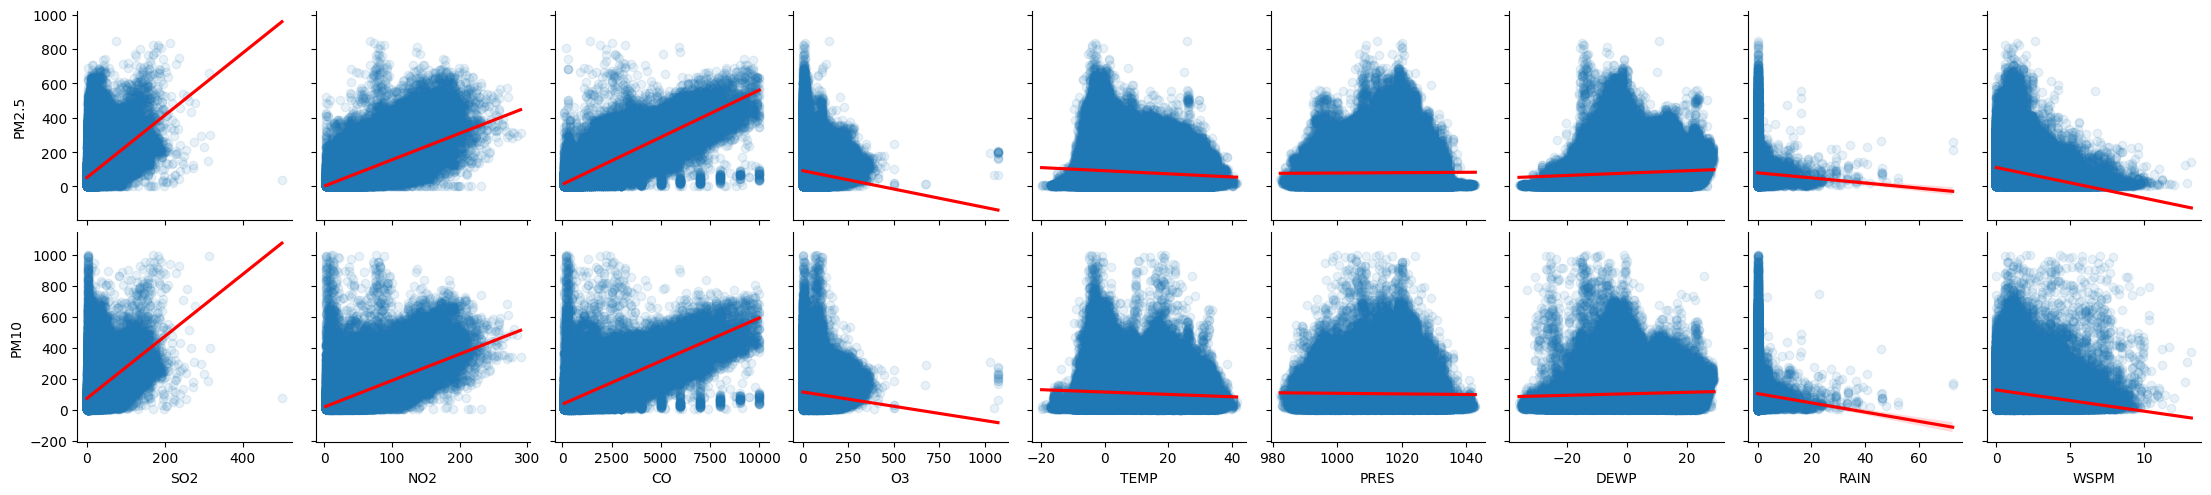

In [20]:
# Numerical variables

sns.pairplot(
    raw_data,
    kind="reg", 
    # kind="scatter", 
    y_vars=["PM2.5", "PM10"], 
    x_vars=['SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN','WSPM'],
    # hue="station",
    plot_kws={
        'line_kws':{'color':'red'}, 
        'scatter_kws': {'alpha': 0.1}
        # 'alpha': 0.25
    }
)

# Take away:
# - NO2 and CO correlate well with PM concentration (should be salient in attention maps)
# - Maybe some outliers clusters in NO2, CO and O3

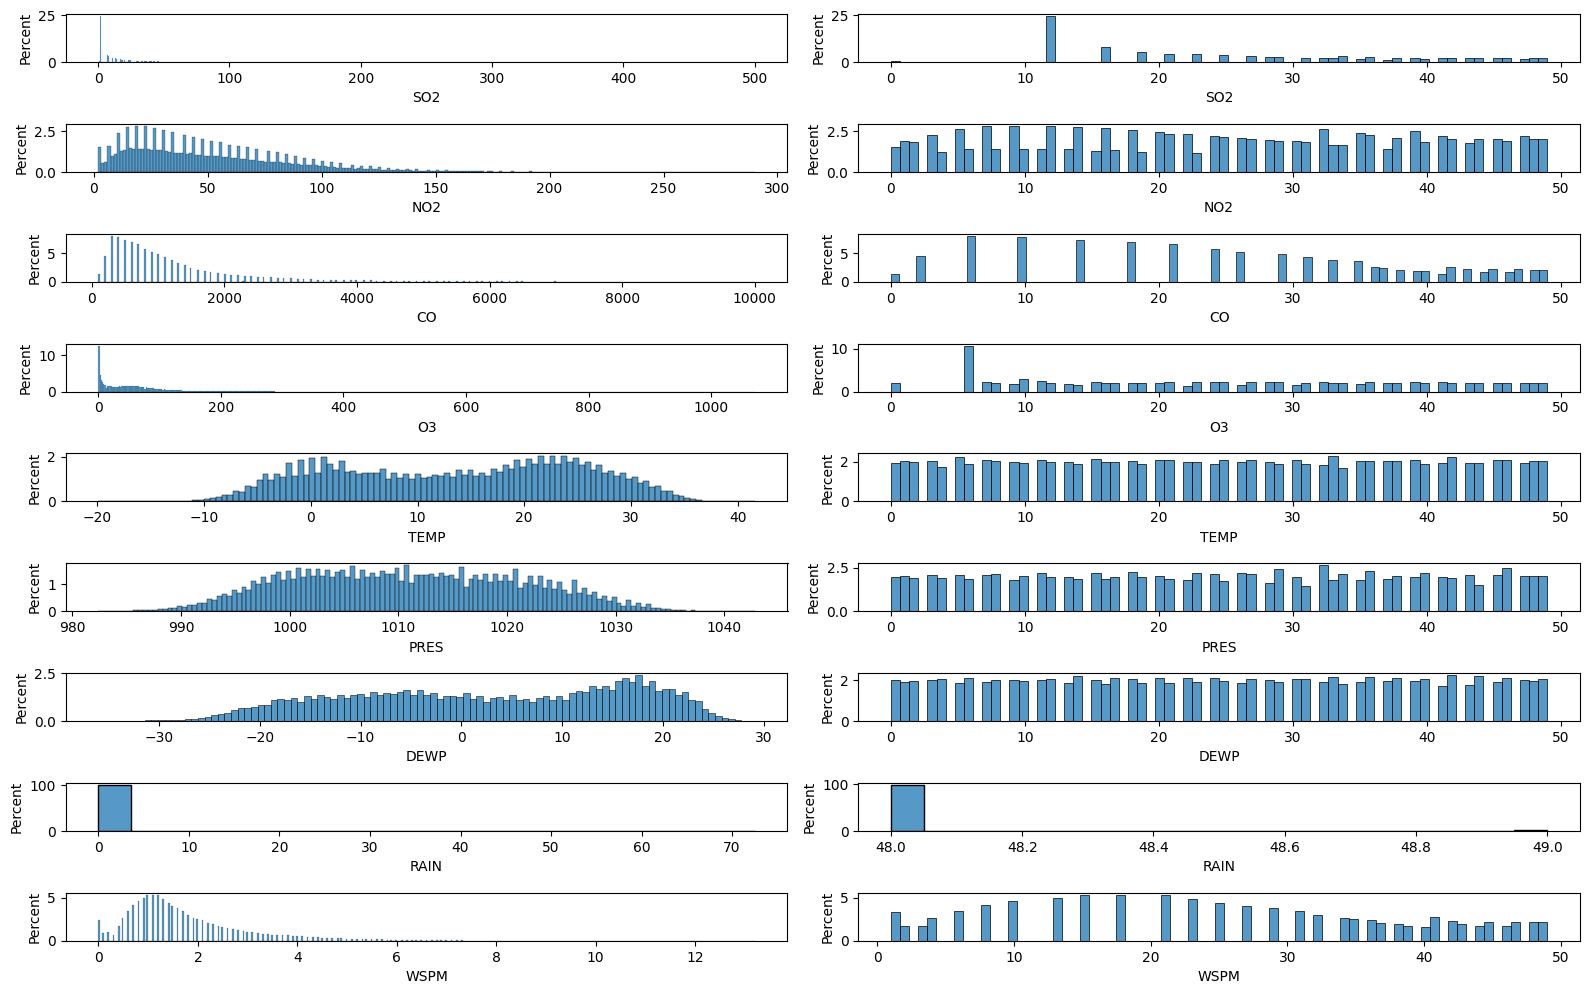

In [39]:
# Comparison of raw vs. preprocessed numerical features

num_features = ['SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN','WSPM']
fig, axes = plt.subplots(nrows=len(num_features), ncols=2, figsize=(16, 10))

for i, f in enumerate(num_features):
    sns.histplot(
        ax=axes[i][0],
        stat="percent",
        x=f, 
        data=raw_data
    )
    # sns.stripplot(
    sns.histplot(
        ax=axes[i][1],
        stat="percent",
        x=f, 
        data=preprocessed_data
    )
plt.tight_layout()

# Take away:
# - need to compare various encoding schemes for numerical variables, e.g., 
# - Gorishniy et al.
# - Binning (quantization, decision-tree leaf, hand-made)
# - SAX + anchor (e.g., mean or starting value)
# - TabPFN

In [58]:
# From TabBERT
def _quantization_binning(nbins, data):
    qtls = np.arange(0.0, 1.0 + 1 / nbins, 1 / nbins)
    bin_edges = np.quantile(data, qtls, axis=0)
    bin_widths = np.diff(bin_edges, axis=0)
    bin_centers = bin_edges[:-1] + bin_widths / 2
    return bin_edges, bin_centers, bin_widths

def _quantize(nbins, inputs, bin_edges):
    quant_inputs = np.zeros(inputs.shape[0])
    for i, x in enumerate(inputs):
        quant_inputs[i] = np.digitize(x, bin_edges)
    quant_inputs = quant_inputs.clip(1, nbins) - 1
    return quant_inputs

# sns.histplot(raw_data["RAIN"], binwidth=1)
t = raw_data[["RAIN", "hour"]].groupby("RAIN").count()
print(t)

# From KBinsDiscretizer
kbd = KBinsDiscretizer(n_bins=50, strategy="uniform", encode="ordinal", subsample=None)
test = kbd.fit_transform(raw_data["RAIN"].to_numpy().reshape(-1, 1))

print(kbd.bin_edges_)
print(np.unique(test.squeeze(1), return_counts=True))

        hour
RAIN        
0.0   367049
0.1     3416
0.2     1686
0.3     1274
0.4      840
...      ...
45.9       2
46.4       6
47.7       1
52.1       2
72.5       2

[248 rows x 1 columns]


/home/razorin/conda_envs/tabformer/lib/python3.8/site-packages/seaborn/categorical.py:3399: UserWarning: 33.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/razorin/conda_envs/tabformer/lib/python3.8/site-packages/seaborn/categorical.py:3399: UserWarning: 29.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/razorin/conda_envs/tabformer/lib/python3.8/site-packages/seaborn/categorical.py:3399: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/razorin/conda_envs/tabformer/lib/python3.8/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/razorin/conda_envs

/home/razorin/conda_envs/tabformer/lib/python3.8/site-packages/seaborn/categorical.py:3399: UserWarning: 37.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/razorin/conda_envs/tabformer/lib/python3.8/site-packages/seaborn/categorical.py:3399: UserWarning: 33.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/razorin/conda_envs/tabformer/lib/python3.8/site-packages/seaborn/categorical.py:3399: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/razorin/conda_envs/tabformer/lib/python3.8/site-packages/seaborn/categorical.py:3399: UserWarning: 19.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/razorin/conda_envs

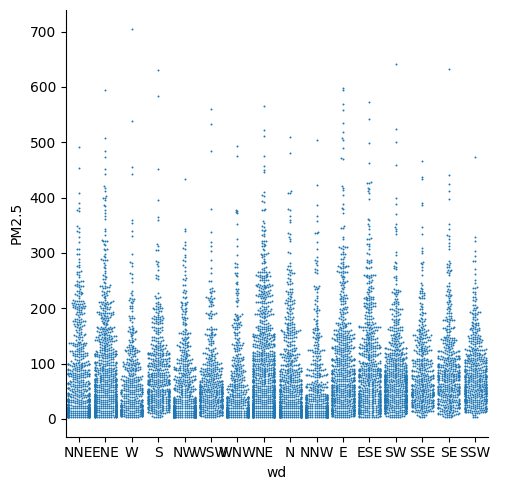

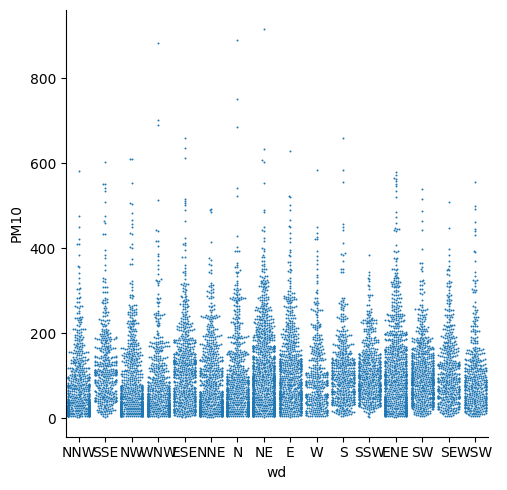

In [ ]:
# Wind direction (wd) categorical variable data exploration

# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))
sns.catplot(
    x='wd', 
    y='PM2.5', 
    # hue='station', 
    kind="swarm",
    data=raw_data.sample(10_000), # takes too long otherwise
    s=2,
)
sns.catplot(
    x='wd', 
    y='PM10', 
    # hue='station', 
    kind="swarm",
    data=raw_data.sample(10_000),
    s=2,
)

# Take-away:
# - WD alone does not seem very informative about the targets